In [29]:
import numpy as np
import dask.array as da
from dask_ml.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from dask_ml.decomposition import IncrementalPCA
from dask_ml.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import mean_squared_error as mse
import warnings
warnings.filterwarnings('ignore')

from pymks import (
    generate_multiphase,
    plot_microstructures,
    PrimitiveTransformer,
    TwoPointCorrelation,
    GenericTransformer,
    solve_fe
)

from toolz.curried import curry, pipe, valmap, itemmap
from modAL.models import ActiveLearner, CommitteeRegressor
from modAL.disagreement import max_std_sampling

import tqdm

In [3]:
def update_learner(oracle_func, x_pool, evaluate_func, learner):
    query_idx, query_instance = learner.query(x_pool)
    query_y = oracle_func(x_pool[query_idx].reshape(1, -1))
    learner.teach(x_pool[query_idx].reshape(1, -1), query_y)
    return evaluate_func(learner), learner

@curry
def evaluate_learner(oracle_func, x_pool, evaluate_func, n_query, learner):
    accuracy_collection = [evaluate_func(learner)]
    for iteration in tqdm.tqdm(range(n_query)):
        accuracy, learner = update_learner(oracle_func, x_pool, evaluate_func, learner)
        accuracy_collection += [accuracy]
    return accuracy_collection, learner

In [4]:
def shuffle(data):
    tmp = np.array(data)
    np.random.shuffle(tmp)
    return da.from_array(tmp, chunks=data.chunks)

def generate_x(shape, seed):
    da.random.seed(seed)
    np.random.seed(seed)

    tmp = [
        generate_multiphase(shape=shape, grain_size=x, volume_fraction=(0.5, 0.5), chunks=50, percent_variance=0.15)
        for x in [(15, 2), (2, 15), (7, 7), (9, 3), (3, 9), (2, 2)]
    ]
    return np.array(shuffle(da.concatenate(tmp)))

In [5]:
def make_model():
    kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 1e2))
    regressor = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
    return Pipeline(steps=(
        ("reshape", GenericTransformer(
            lambda x: x.reshape(x.shape[0], x_data.shape[1], x_data.shape[2])
        )),
        ("discritize",PrimitiveTransformer(n_state=2, min_=0.0, max_=1.0)),
        ("correlations",TwoPointCorrelation(periodic_boundary=True, cutoff=31, correlations=[(0, 1), (1, 1)])),
        ('flatten', GenericTransformer(lambda x: x.reshape(x.shape[0], -1))),
        ('pca', IncrementalPCA(n_components=3, svd_solver='full')),
        ('poly', PolynomialFeatures(degree=3)),
        ('regressor', regressor)
    ))

In [6]:
@curry
def oracle_func(shape, x_data):
    y_stress = solve_fe(x_data.reshape((-1,) + shape),
                        elastic_modulus=(1.3, 2.5),
                        poissons_ratio=(0.42, 0.35),
                        macro_strain=0.001)['stress'][..., 0]

    return np.array(da.average(y_stress.reshape(y_stress.shape[0], -1), axis=1))

In [7]:
def plot_parity(y_test, y_predict):
    pred_data = np.array([y_test, y_predict])
    line = np.min(pred_data), np.max(pred_data)
    plt.plot(pred_data[0], pred_data[1], 'o', color='#f46d43', label='Testing Data')
    plt.plot(line, line, '-', linewidth=3, color='#000000')
    plt.title('Goodness of Fit', fontsize=20)
    plt.xlabel('Actual', fontsize=18)
    plt.ylabel('Predicted', fontsize=18)
    plt.legend(loc=2, fontsize=15)
    return plt

In [8]:
def three_way_split(x_data, props, random_state):
    x_0, x_ = train_test_split(x_data, train_size=props[0], random_state=random_state)
    x_1, x_2 = train_test_split(x_, train_size=props[1] / (1 - props[0]), random_state=random_state)
    return flatten(x_0), flatten(x_1), flatten(x_2)

In [9]:
def flatten(x_data):
    return x_data.reshape(x_data.shape[0], -1)

In [10]:
@curry
def evaluate_func(x_test, y_test, learner):
    return mse(y_test, learner.predict(x_test))

# Active Learning!

## Generate Data

In [11]:
grid_shape = (41, 41)
n_sample_per_class = 100
x_data = generate_x((n_sample_per_class,) + grid_shape, 5)
x_pool, x_test, x_train = three_way_split(x_data, (0.8, 0.16), 99)
oracle = oracle_func(grid_shape)

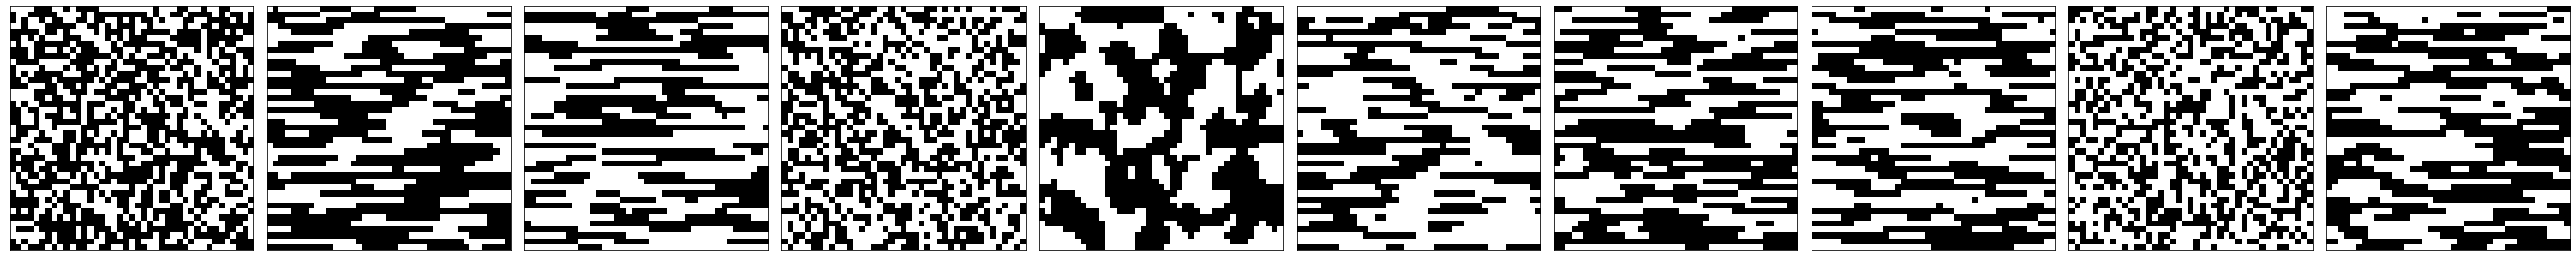

In [12]:
plot_microstructures(*x_data[:10], cmap='gray', colorbar=False);

In [13]:
print(x_test.shape)
print(x_train.shape)
print(x_pool.shape)
print(x_data.shape)

(96, 1681)
(24, 1681)
(480, 1681)
(600, 41, 41)


## Generate the necessary oracle data

In [14]:
%%time
y_test = oracle(x_test)

CPU times: user 14min 20s, sys: 13.6 s, total: 14min 34s
Wall time: 1min 22s


In [15]:
%%time
y_train = oracle(x_train)

CPU times: user 3min 40s, sys: 3.71 s, total: 3min 43s
Wall time: 21.1 s


## Set up the active learners

One is a GPR using the maximum std and the other is random

In [34]:
std_learner = ActiveLearner(
    estimator=make_model(),
    query_strategy=lambda model, x_: pipe(
        model.predict(x_, return_std=True)[1],
        np.argmax,
        lambda i: (i, x_[i])
    ),
    X_training=x_train,
    y_training=y_train
)

random_learner = ActiveLearner(
    estimator=make_model(),
    query_strategy=lambda model, x_: pipe(
        np.random.randint(0, len(x_)),
        lambda i: (i, x_[i])
    ),
    X_training=x_train,
    y_training=y_train
)

ensemble_learner = CommitteeRegressor(
    learner_list=[
        ActiveLearner(
            estimator=make_model(),
            X_training=x_train_,
            y_training=y_train_
        )
        for x_train_, y_train_ in zip(np.array_split(x_train, 5), np.array_split(y_train, 5))
    ],
    query_strategy=max_std_sampling
)

learners = dict(
    std=std_learner,
    random=random_learner,
    ensemble=ensemble_learner
)

## Run the learners

In [35]:
def evaluate_item(item):
    name, learner = item
    print('evaluating', name)
    return name, evaluate_learner(oracle, x_pool, evaluate_func(x_test, y_test), 40, learner)

learner_accuracy = itemmap(evaluate_item, learners)

evaluating std


100%|██████████| 40/40 [01:13<00:00,  1.85s/it]


evaluating random


100%|██████████| 40/40 [01:06<00:00,  1.67s/it]


evaluating ensemble


100%|██████████| 40/40 [02:58<00:00,  4.46s/it]


## The results

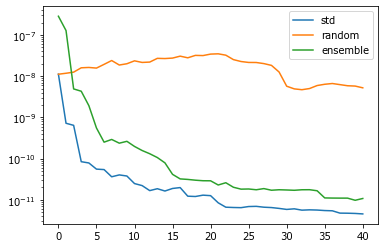

In [36]:
for k, v in learner_accuracy.items():
    plt.semilogy(v[0], label=k)
plt.legend()


## Check what the accuracy actually looks like

In [60]:
y_pred = learner_accuracy['std'][1].predict(x_test)

<module 'matplotlib.pyplot' from '/nix/store/c8sgkmibi2vyfw75w9vai2917j5smvq7-python3.8-matplotlib-3.3.1/lib/python3.8/site-packages/matplotlib/pyplot.py'>

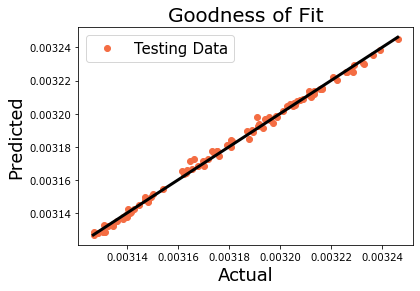

In [61]:
plot_parity(y_test, y_pred)

## Sandbox